# ST-HDBSCAN: Spatiotemporal Hierarchical DBSCAN for Trajectory Data

## Abstract

The study of human mobility has advanced greatly in recent years due to the availability of
commercial large-scale GPS trajectory datasets [3]. However, the validity of findings that use
these datasets depends heavily on the robustness of their pre-processing methods. An important
step in the processing of mobility data is the detection of stops within GPS trajectories, for
which many clustering algorithms have been proposed [4, 8, 6, 1]. Yet, the high sparsity of
commercial GPS data can affect the performance of these stop-detection algorithms.
In the case of DBSCAN, while it initially identifies dense regions, it can often over-cluster
or under-cluster due to noise and weakly connected points given the chosen ε. ST-DBSCAN [4]
uses two distance thresholds, Eps1 for spatial and Eps2 for non-spatial values. The algorithm
compares the average non-spatial value, such as temperature, of a cluster with a new com-
ing value, to prevent merging adjacent clusters. Nevertheless, datasets that include this kind
of information are not comparable to realistic GPS-based trajectories. A promising algorithm
is T-DBSCAN [6], which searches forward in time for a continuous density-based neighbor-
hood of core points. Points spatially close, within Eps, and within a roaming threshold, CEps, are included in a cluster. Additionally, we used a time-augmented DBSCAN algorithm, TA-DBSCAN, which recursively processes the clusters obtained from DBSCAN to address the issue of initial clusters overlapping in time. However, methods [9] that validate stop-detection algorithms based on synthetic data show that these can omit, merge, or split stops based on the selection of epsilon and sparsity of the data.

If we define parameters that may be considered fine (low ε), it might completely miss a stop at a larger location. In contrast, coarse parameters (large ε) may struggle to differentiate stops within small neighboring locations [3]. Since different venues vary in stop durations and areas, this could influence the parameter choices [9]. To address this parameter selection limitation, we propose a spatiotemporal variation of Hierarchical DBSCAN [5], ST-HDBSCAN. Unlike DBSCAN, which relies on one threshold of density to cluster points, our variation constructs separate structures for space and time distances that preserve density-based connections in these two dimensions. This approach ensures that when pruning the hierarchical tree structure needed for cluster formation, we account for varying spatiotemporal densities. As a result, clusters emerge naturally without requiring specific time and space thresholds, working effectively across different data sparsity levels.

In [51]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from pyproj import Transformer
import nomad.io.base as loader
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.city_gen as cg
import nomad.visit_attribution as va

In [34]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

# data = loader.from_file("../../nomad/data/gc_sample.csv")
data = loader.from_file("../../nomad/data/gc_3_stops.csv", timestamp='unix_timestamp', datetime='local_timestamp', user_id='identifier')

/Users/andresmondragon/nomad/nomad/io/base.py:614: UserWarning: The 'local_timestamp' column has timezone-naive records consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column has timezone-naive records consider localizing or using unix timestamps.")


In [35]:
data.rename(columns={'unix_timestamp':'timestamp'}, inplace=True)

In [36]:
data

,x,y,local_timestamp,timestamp,identifier
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie
...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie


In [ ]:
stop_detection_algos = ['lachesis', 'ta-dbscan', 'hdbscan']

for algo in stop_detection_algos:
    if algo == 'lachesis':
        stop_table = LACHESIS.lachesis(traj=user_sample,
                                       dur_min=DUR_MIN,
                                       dt_max=DT_MAX,
                                       delta_roam=DELTA_ROAM,
                                       traj_cols=traj_cols,
                                       keep_col_names = False)
        labels = LACHESIS._lachesis_labels(traj=traj,
                                           dur_min=5,
                                           dt_max=60,
                                           delta_roam=3,
                                           traj_cols=traj_cols)
    elif algo == 'ta-dbscan':
        stop_table = TADBSCAN.temporal_dbscan(data=user_sample,
                                              time_thresh=TIME_THRESH,
                                              dist_thresh=DIST_THRESH,
                                              min_pts=MIN_PTS,
                                              traj_cols=traj_cols)
        labels = TADBSCAN._temporal_dbscan_labels(data=user_sample,
                                                  time_thresh=TIME_THRESH,
                                                  dist_thresh=DIST_THRESH,
                                                  min_pts=MIN_PTS,
                                                  traj_cols=traj_cols,)
    else:
        stop_table = HDBSCAN.st_hdbscan(traj = traj,
                                        traj_cols = traj_cols,
                                        time_thresh = 600,
                                        min_pts = 2,
                                        min_cluster_size = 3)
        labels = HDBSCAN.hdbscan_labels(traj = traj,
                                        traj_cols = traj_cols,
                                        time_thresh = 600,
                                        min_pts = 2,
                                        min_cluster_size = 3)


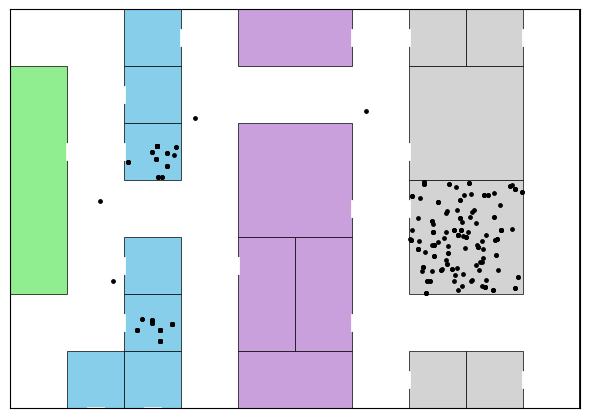

In [6]:
%matplotlib inline

plot_df = data.copy()

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()
plt.show()

In [7]:
traj_cols = {'x':'x',
             'y':'y',
             'timestamp': 'timestamp'}

In [8]:
time_pairs, times = HDBSCAN._find_temp_neighbors(times = data['timestamp'], time_thresh = 60, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(data, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=5)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 10)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)

In [9]:
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(traj = data,
                       traj_cols = traj_cols,
                       time_thresh = 60,
                       min_pts = 5,
                       min_cluster_size = 10)
sample_labels_hdbscan

time
1717200000    3
1717200060    3
1717200120    3
1717200180    3
1717200240    3
             ..
1717217760    2
1717217820    2
1717217880    2
1717217940    2
1717218000    2
Name: cluster, Length: 301, dtype: int64

In [ ]:
data

,x,y,local_timestamp,timestamp,identifier
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie
...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie


In [37]:
data.merge(sample_labels_hdbscan, left_on='timestamp', right_index=True)

,x,y,local_timestamp,timestamp,identifier,cluster
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie,3
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie,3
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie,3
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie,3
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie,3
...,...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie,2
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie,2
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie,2
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie,2


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../data/metrics_simulated.csv")

metrics = ['f1-score', 'splitting', 'merging']

for metric in metrics:
    plt.figure()
    df.boxplot(column=metric, by='method')
    plt.title(f'{metric} by Method')
    plt.suptitle('')
    plt.xlabel('Method')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()

plt.show()

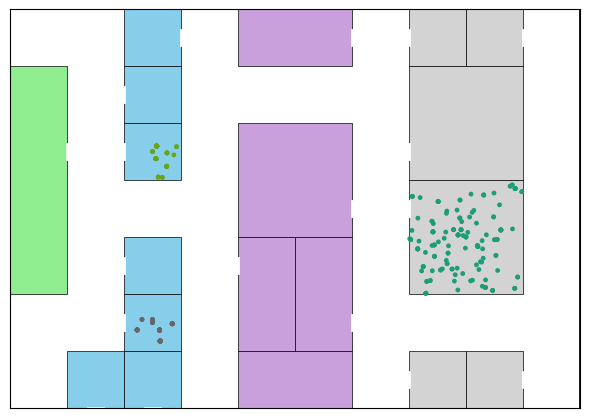

In [50]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = data.merge(sample_labels_hdbscan, left_on='timestamp', right_index=True)

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
del cluster_mapping[-1]
mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
colors = list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [43]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
hdbscan_stop_table = HDBSCAN.st_hdbscan(traj = data,
                                        is_long_lat = False,
                                        is_datetime = False,
                                        traj_cols = traj_cols,
                                        complete_output = True,
                                        time_thresh = 60,
                                        min_pts = 5,
                                        min_cluster_size = 10)
hdbscan_stop_table

,start_timestamp,end_timestamp,x,y,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
2,1717207440,1717218000,19.861204,10.035797,2.451501,162,176,4.0
3,1717200000,1717203300,14.574002,11.594415,0.620968,56,55,1.0
4,1717203720,1717207200,14.624768,8.366804,0.625577,59,58,1.0


In [28]:
hdbscan_stop_table.index

Index([2, 3, 4], dtype='int64', name='cluster')

In [55]:
va.point_in_polygon(traj=data,
                    labels=sample_labels_hdbscan,
                    stop_table=hdbscan_stop_table,
                    traj_cols=traj_cols,
                    is_datetime=False,
                    is_long_lat=False)

/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'uid' specified for 'uid' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")
/Users/andresmondragon/nomad/nomad/io/base.py:55: UserWarning: Trajectory column 'timestamp' specified for 'timestamp' not found in DataFrame.
  warnings.warn(f"Trajectory column '{value}' specified for '{key}' not found in DataFrame.")


,start_timestamp,end_timestamp,x,y,diameter,n_pings,duration,max_gap,location
cluster,,,,,,,,,
2,1717207440,1717218000,19.861204,10.035797,2.451501,162,176,4.0,r-x18-y10
3,1717200000,1717203300,14.574002,11.594415,0.620968,56,55,1.0,h-x13-y11
4,1717203720,1717207200,14.624768,8.366804,0.625577,59,58,1.0,h-x13-y8


## Testing on new data

In [18]:
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)
diaries_df = loader.from_file("../../nomad/data/diaries/", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)

### One Agent

In [19]:
traj = sparse_df[sparse_df['uid'] == 'adoring_keldysh']
traj.loc[:,'local_timestamp'] = pd.to_datetime(traj['local_timestamp'])
diary = diaries_df[diaries_df['uid'] == 'adoring_keldysh']
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

In [20]:
one_day_traj = traj[traj['date'] == '2024-01-01']
one_day_traj.head()

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date
0,adoring_keldysh,1704093060,38.321357,-36.666491,4.265914e+06,-4.392721e+06,2024-01-01 09:11:00+02:00,11.25,2024-01-01
1,adoring_keldysh,1704094080,38.321313,-36.666492,4.265909e+06,-4.392721e+06,2024-01-01 09:28:00+02:00,11.25,2024-01-01
2,adoring_keldysh,1704094500,38.321364,-36.666583,4.265915e+06,-4.392734e+06,2024-01-01 09:35:00+02:00,11.25,2024-01-01
3,adoring_keldysh,1704094620,38.321359,-36.666541,4.265914e+06,-4.392728e+06,2024-01-01 09:37:00+02:00,11.25,2024-01-01
4,adoring_keldysh,1704095100,38.321314,-36.666566,4.265909e+06,-4.392732e+06,2024-01-01 09:45:00+02:00,11.25,2024-01-01


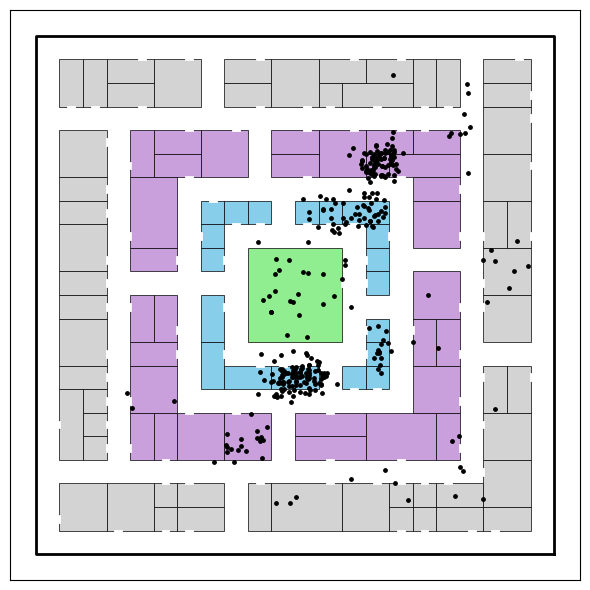

In [21]:
%matplotlib inline

plot_df = traj.copy()
# plot_df = one_day_traj.copy()
plot_df.loc[:,'x'] = (plot_df['x'] - 4265699)/15
plot_df.loc[:,'y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import warnings

def poi_map(traj, poi_table, traj_cols=None, max_distance=1, **kwargs):
    """
    Map pings in the trajectory to the POI table.

    Parameters
    ----------
    traj : pd.DataFrame
        The trajectory DataFrame containing x and y coordinates.
    poi_table : gpd.GeoDataFrame
        The POI table containing building geometries and IDs.
    traj_cols : list
        The columns in the trajectory DataFrame to be used for mapping.
    **kwargs : dict
        Additional keyword arguments.
    
    Returns
    -------
    pd.Series
        A Series containing the building IDs corresponding to the pings in the trajectory.
    """
    # Build pings GeoDataFrame
    pings_df = traj[['x', 'y']].copy()
    pings_df["pings_geometry"] = pings_df.apply(lambda row: Point(row["x"], row["y"]), axis=1)
    pings_df = gpd.GeoDataFrame(pings_df, geometry="pings_geometry", crs=poi_table.crs)
    
    # First spatial join (within)
    pings_df = gpd.sjoin(pings_df, poi_table, how="left", predicate="within")
    
    # Identify unmatched pings
    unmatched_mask = pings_df["building_id"].isna()
    unmatched_pings = pings_df[unmatched_mask].drop(columns=["building_id", "index_right"])
    
    if not unmatched_pings.empty:
        # Nearest spatial join for unmatched pings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*")
            nearest = gpd.sjoin_nearest(unmatched_pings, poi_table, how="left", max_distance=max_distance)

        # Keep only the first match for each original ping
        nearest = nearest.groupby(nearest.index).first()

        # Update original DataFrame with nearest matches
        pings_df.loc[unmatched_mask, "building_id"] = nearest["building_id"].values

    return pings_df["building_id"]

### One day

In [24]:
plot_df = one_day_traj.copy()
plot_df.loc[:,'x'] = (plot_df['x'] - 4265699)/15
plot_df.loc[:,'y'] = (plot_df['y'] + 4392976)/15
gdf = gpd.read_file('../garden_city.geojson')
poi_labels = poi_map(plot_df,
                     poi_table=gdf)

In [25]:
test_building_traj = one_day_traj.merge(poi_labels, left_index=True, right_index=True)
test_building_traj

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date,building_id
0,adoring_keldysh,1704093060,38.321357,-36.666491,4.265914e+06,-4.392721e+06,2024-01-01 09:11:00+02:00,11.25,2024-01-01,w-x14-y15
1,adoring_keldysh,1704094080,38.321313,-36.666492,4.265909e+06,-4.392721e+06,2024-01-01 09:28:00+02:00,11.25,2024-01-01,w-x14-y15
2,adoring_keldysh,1704094500,38.321364,-36.666583,4.265915e+06,-4.392734e+06,2024-01-01 09:35:00+02:00,11.25,2024-01-01,w-x14-y15
3,adoring_keldysh,1704094620,38.321359,-36.666541,4.265914e+06,-4.392728e+06,2024-01-01 09:37:00+02:00,11.25,2024-01-01,w-x14-y15
4,adoring_keldysh,1704095100,38.321314,-36.666566,4.265909e+06,-4.392732e+06,2024-01-01 09:45:00+02:00,11.25,2024-01-01,w-x14-y15
5,adoring_keldysh,1704095400,38.321369,-36.666503,4.265915e+06,-4.392723e+06,2024-01-01 09:50:00+02:00,11.25,2024-01-01,w-x14-y15
6,adoring_keldysh,1704096180,38.321360,-36.666593,4.265914e+06,-4.392736e+06,2024-01-01 10:03:00+02:00,11.25,2024-01-01,w-x14-y15
7,adoring_keldysh,1704096780,38.321326,-36.666600,4.265911e+06,-4.392736e+06,2024-01-01 10:13:00+02:00,11.25,2024-01-01,w-x14-y15
8,adoring_keldysh,1704099600,38.321418,-36.666508,4.265921e+06,-4.392724e+06,2024-01-01 11:00:00+02:00,11.25,2024-01-01,w-x14-y15
9,adoring_keldysh,1704100200,38.321402,-36.666487,4.265919e+06,-4.392721e+06,2024-01-01 11:10:00+02:00,11.25,2024-01-01,w-x15-y18


In [ ]:
time_pairs, times = HDBSCAN._find_temp_neighbors(times = one_day_traj['timestamp'], time_thresh = 600, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(one_day_traj, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=2)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 3)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(label_history_df, selected_clusters)

In [373]:
merged_data_hdbscan = test_building_traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan

,uid,timestamp,longitude,latitude,x,y,local_timestamp,ha,date,building_id,time,cluster
0,adoring_keldysh,1704093060,38.321357,-36.666491,4.265914e+06,-4.392721e+06,2024-01-01 09:11:00+02:00,11.25,2024-01-01,w-x14-y15,1704093060,3
1,adoring_keldysh,1704094080,38.321313,-36.666492,4.265909e+06,-4.392721e+06,2024-01-01 09:28:00+02:00,11.25,2024-01-01,w-x14-y15,1704094080,3
2,adoring_keldysh,1704094500,38.321364,-36.666583,4.265915e+06,-4.392734e+06,2024-01-01 09:35:00+02:00,11.25,2024-01-01,w-x14-y15,1704094500,3
3,adoring_keldysh,1704094620,38.321359,-36.666541,4.265914e+06,-4.392728e+06,2024-01-01 09:37:00+02:00,11.25,2024-01-01,w-x14-y15,1704094620,3
4,adoring_keldysh,1704095100,38.321314,-36.666566,4.265909e+06,-4.392732e+06,2024-01-01 09:45:00+02:00,11.25,2024-01-01,w-x14-y15,1704095100,3
5,adoring_keldysh,1704095400,38.321369,-36.666503,4.265915e+06,-4.392723e+06,2024-01-01 09:50:00+02:00,11.25,2024-01-01,w-x14-y15,1704095400,3
6,adoring_keldysh,1704096180,38.321360,-36.666593,4.265914e+06,-4.392736e+06,2024-01-01 10:03:00+02:00,11.25,2024-01-01,w-x14-y15,1704096180,3
7,adoring_keldysh,1704096780,38.321326,-36.666600,4.265911e+06,-4.392736e+06,2024-01-01 10:13:00+02:00,11.25,2024-01-01,w-x14-y15,1704096780,3
8,adoring_keldysh,1704099600,38.321418,-36.666508,4.265921e+06,-4.392724e+06,2024-01-01 11:00:00+02:00,11.25,2024-01-01,w-x14-y15,1704099600,3
9,adoring_keldysh,1704100200,38.321402,-36.666487,4.265919e+06,-4.392721e+06,2024-01-01 11:10:00+02:00,11.25,2024-01-01,w-x15-y18,1704100200,3


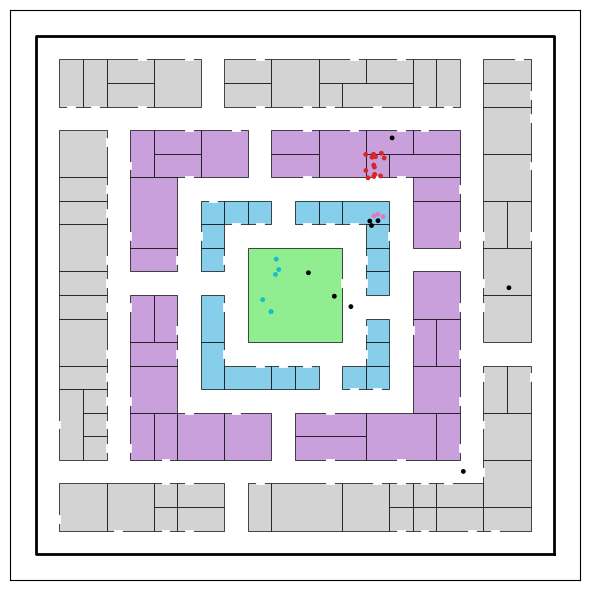

In [374]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = one_day_traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan.loc[:,'x'] = (merged_data_hdbscan['x'] - 4265699)/15
merged_data_hdbscan.loc[:,'y'] = (merged_data_hdbscan['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_hdbscan['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

### All days

In [526]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

time_pairs, times = HDBSCAN._find_temp_neighbors(times = traj['timestamp'], time_thresh = 600, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(traj, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=2)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 3)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(label_history_df, selected_clusters)

In [527]:
label_history_df

,time,cluster_id,dendrogram_scale
0,1704697860,0,NaN
1,1704695820,0,NaN
2,1704495120,0,NaN
3,1704691740,0,NaN
4,1704429600,0,NaN
...,...,...,...
117987,1704642540,-1,0.153148
117988,1704134640,-1,0.153148
117989,1704640500,-1,0.153148
117990,1704439800,-1,0.153148


In [528]:
sample_labels_hdbscan['cluster'].nunique()

44

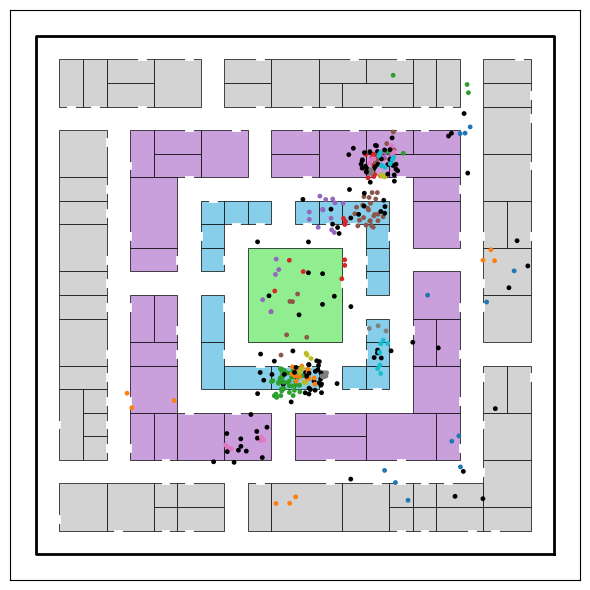

In [551]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan.loc[:,'x'] = (merged_data_hdbscan['x'] - 4265699)/15
merged_data_hdbscan.loc[:,'y'] = (merged_data_hdbscan['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_hdbscan['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [642]:
hdbscan_stop_table = HDBSCAN.st_hdbscan(traj = traj,
                                        is_long_lat = False,
                                        is_datetime = False,
                                        traj_cols = traj_cols,
                                        complete_output = True,
                                        time_thresh = 600,
                                        min_pts = 2,
                                        min_cluster_size = 3)
hdbscan_stop_table

,start_time,end_time,x,y,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
4,1.704292e+09,1.704293e+09,4.265972e+06,-4.392708e+06,7.658003,3.0,14.0,11.0
9,1.704196e+09,1.704197e+09,4.265928e+06,-4.392930e+06,24.197871,3.0,10.0,8.0
13,1.704625e+09,1.704643e+09,4.265986e+06,-4.392815e+06,57.221606,3.0,298.0,297.0
17,1.704629e+09,1.704631e+09,4.265964e+06,-4.392904e+06,19.771899,3.0,24.0,16.0
20,1.704592e+09,1.704600e+09,4.265867e+06,-4.392863e+06,18.028587,16.0,143.0,46.0
21,1.704627e+09,1.704628e+09,4.265861e+06,-4.392944e+06,13.258592,3.0,20.0,18.0
22,1.704465e+09,1.704468e+09,4.265760e+06,-4.392883e+06,30.373510,3.0,45.0,33.0
24,1.704537e+09,1.704539e+09,4.265991e+06,-4.392789e+06,8.326219,3.0,33.0,21.0
25,1.704535e+09,1.704540e+09,4.265974e+06,-4.392677e+06,49.207847,3.0,77.0,59.0


In [ ]:
lachesis_labels = LACHESIS._lachesis_labels(traj=traj,
                                            dur_min=5,
                                            dt_max=60,
                                            delta_roam=3,
                                            traj_cols=traj_cols)

lachesis_labels

timestamp
1704093060   -1
1704094080   -1
1704094500   -1
1704094620   -1
1704095100   -1
             ..
1704705420   -1
1704705900   -1
1704706920   -1
1704707640   -1
1704707880   -1
Length: 344, dtype: int64

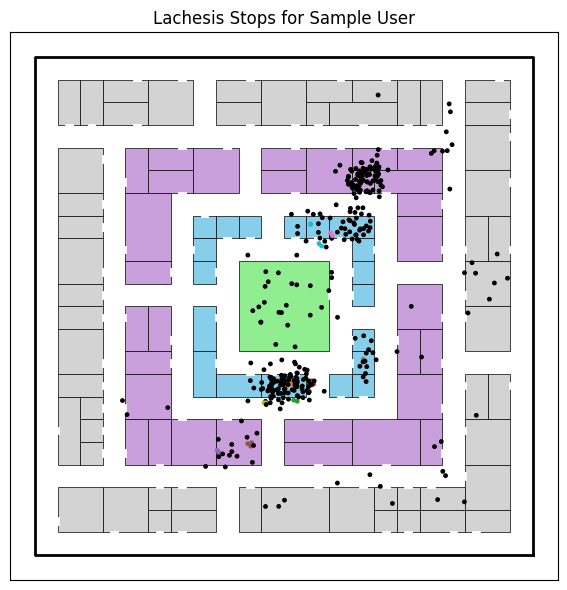

In [577]:
%matplotlib inline

# Merging sample data with labels
merged_data_lachesis = traj.merge(lachesis_labels.to_frame(name='cluster'), left_on='timestamp', right_index=True)
merged_data_lachesis.loc[:,'x'] = (merged_data_lachesis['x'] - 4265699)/15
merged_data_lachesis.loc[:,'y'] = (merged_data_lachesis['y'] + 4392976)/15
# merged_data_lachesis = merged_data_lachesis[~(merged_data_lachesis['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_lachesis['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_lachesis['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_lachesis['x'], 
           merged_data_lachesis['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("Lachesis Stops for Sample User")
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

### HDBSCAN by date

In [474]:
sample_labels_hdbscan_by_date = traj.groupby(['date']).apply(lambda x: HDBSCAN.st_hdbscan(traj = x,
                                                          is_long_lat = False,
                                                          is_datetime = False,
                                                          traj_cols = traj_cols,
                                                          complete_output = True,
                                                          time_thresh = 600,
                                                          min_pts = 2,
                                                          min_cluster_size = 3),
                            include_groups=False)
sample_labels_hdbscan_by_date

uid   timestamp  longitude   latitude  \
date                                                               
2024-01-01 0   adoring_keldysh  1704093060  38.321357 -36.666491   
           1   adoring_keldysh  1704094080  38.321313 -36.666492   
           2   adoring_keldysh  1704094500  38.321364 -36.666583   
           3   adoring_keldysh  1704094620  38.321359 -36.666541   
           4   adoring_keldysh  1704095100  38.321314 -36.666566   
...                        ...         ...        ...        ...   
2024-01-08 50  adoring_keldysh  1704705420  38.321292 -36.666521   
           51  adoring_keldysh  1704705900  38.321341 -36.666562   
           52  adoring_keldysh  1704706920  38.321406 -36.666544   
           53  adoring_keldysh  1704707640  38.321465 -36.666517   
           54  adoring_keldysh  1704707880  38.321339 -36.666620   

                          x             y           local_timestamp     ha  \
date                                                                         
2024-01-01 0   4.265914e+06 -4.392721e+06 2024-01-01 09:11:00+02:00  11.25   
           1   4.265909e+06 -4.392721e+06 2024-01-01 09:28:00+02:00  11.25   
           2   4.265915e+06 -4.392734e+06 2024-01-01 09:35:00+02:00  11.25   
           3   4.265914e+06 -4.392728e+06 2024-01-01 09:37:00+02:00  11.25   
           4   4.265909e+06 -4.392732e+06 2024-01-01 09:45:00+02:00  11.25   
...                     ...           ...                       ...    ...   
2024-01-08 50  4.265907e+06 -4.392726e+06 2024-01-08 11:17:00+02:00  11.25   
           51  4.265912e+06 -4.392731e+06 2024-01-08 11:25:00+02:00  11.25   
           52  4.265919e+06 -4.392729e+06 2024-01-08 11:42:00+02:00  11.25   
           53  4.265926e+06 -4.392725e+06 2024-01-08 11:54:00+02:00  11.25   
           54  4.265912e+06 -4.392739e+06 2024-01-08 11:58:00+02:00  11.25   

                     time  cluster  
date                                
2024-01-01 0   1704093060        3  
           1   1704094080        3  
           2   1704094500        3  
           3   1704094620        3  
           4   1704095100        3  
...                   ...      ...  
2024-01-08 50  1704705420       -1  
           51  1704705900        9  
           52  1704706920       15  
           53  1704707640       14  
           54  1704707880       -1  

[344 rows x 10 columns]

In [475]:
sample_labels_hdbscan_by_date['cluster'].nunique()

17

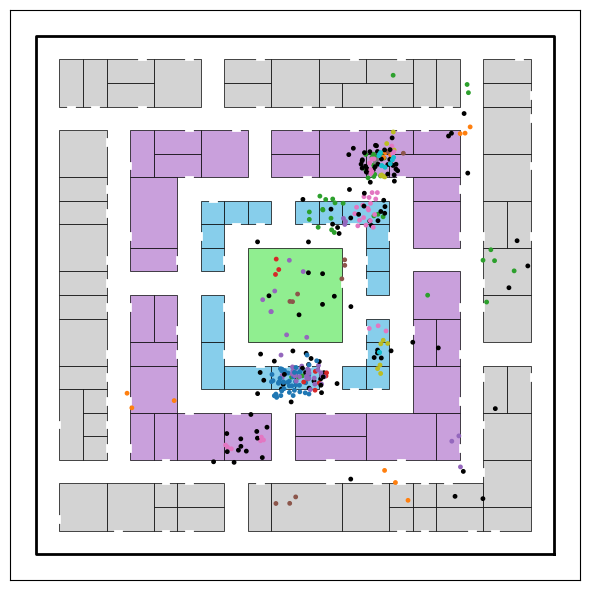

In [476]:
%matplotlib inline

# Merging sample data with labels
sample_labels_hdbscan_by_date.loc[:,'x'] = (sample_labels_hdbscan_by_date['x'] - 4265699)/15
sample_labels_hdbscan_by_date.loc[:,'y'] = (sample_labels_hdbscan_by_date['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(sample_labels_hdbscan_by_date['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = sample_labels_hdbscan_by_date['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(sample_labels_hdbscan_by_date['x'], 
           sample_labels_hdbscan_by_date['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

## Simple test synthetic data

In [91]:
# Synthetic dataset with connected 2 components connected by an edge with weight infinity
def synthetic_graph_with_cc():
    # MST edges within cluster A
    edges_a = [(1, 2, 0.15), (2, 3, 0.20)]
    # MST edges within cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.19)]
    # Artificial high-weight edge between cluster A and B
    bridge_edge = [(3, 4, np.inf)]

    # Combine into full MST+ext
    mst_ext_df = pd.DataFrame(edges_a + edges_b + bridge_edge, columns=["from", "to", "weight"])

    return mst_ext_df

# Synthetic dataset with connected 4 components
def synthetic_graph_with_4cc():
    # Cluster A
    edges_a = [(1, 2, 5), (2, 3, 7)]
    # Cluster B
    edges_b = [(4, 5, 5), (5, 6, 8)]
    # Cluster C
    edges_c = [(7, 8, 2), (8, 9, 6)]
    # Cluster D
    edges_d = [(10, 11, 4), (11, 12, 8)]

    # Bridge edges with high weights
    bridges = [
        (3, 4, np.inf),  # A to B
        (6, 7, 20),  # B to C
        (9, 10, 15)  # C to D
    ]

    all_edges = edges_a + edges_b + edges_c + edges_d + bridges
    mst_ext_df = pd.DataFrame(all_edges, columns=["from", "to", "weight"])

    return mst_ext_df

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import imageio
import os

def visualize_mst_evolution(mst_df, gif_filename="mst_evolution.gif", duration=500.0):
    # Build full graph and collect all nodes
    full_edges = []
    all_nodes = set()

    for u, v, w in mst_df.itertuples(index=False):
        w_val = 1e6 if np.isinf(w) else w
        inv_w = 1.0 / w_val if w_val > 0 else 0.001
        label = "∞" if np.isinf(w) else f"{w:.2f}"
        full_edges.append((u, v, {'weight': w_val, 'inv_weight': inv_w, 'label': label}))
        all_nodes.update([u, v])

    # Sort edges by decreasing weight
    full_edges_sorted = sorted(full_edges, key=lambda x: -x[2]['weight'])

    # Fixed layout (use inverse weights)
    G_full = nx.Graph()
    G_full.add_nodes_from(all_nodes)
    G_full.add_edges_from(full_edges)
    pos = nx.spring_layout(G_full, weight='inv_weight', seed=50)

    # Iteratively remove edges and save frames
    frames = []
    for i in range(len(full_edges_sorted) + 1):
        G = nx.Graph()
        G.add_nodes_from(all_nodes)
        remaining_edges = full_edges_sorted[i:]
        G.add_edges_from(remaining_edges)

        edge_labels = nx.get_edge_attributes(G, 'label')

        # Draw and save
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='gray', width=2)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, rotate=False,
                                     font_size=10, bbox=dict(facecolor='white', edgecolor='none'))
        plt.axis('off')

        # Add epsilon text (for removed edge weight)
        if i > 0:
            removed_edge = full_edges_sorted[i - 1]
            removed_weight = removed_edge[2]['weight']
            epsilon_display = "∞" if removed_weight >= 1e6 else f"{removed_weight:.2f}"
            plt.text(
                0.05, 0.95, f"ε = {epsilon_display}",
                transform=plt.gca().transAxes,
                fontsize=14, fontweight='bold',
                verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
            )

        fname = f"mst_frame_{i:02d}.png"
        plt.savefig(fname)
        frames.append(fname)
        plt.close()

    # Create GIF
    with imageio.get_writer(gif_filename, mode="I", duration=duration, loop=0) as writer:
        for fname in frames:
            writer.append_data(imageio.imread(fname))

        # Add final frame pause
        final_img = imageio.imread(frames[-1])
        for _ in range(5):
            writer.append_data(final_img)

    for fname in frames:
        os.remove(fname)

In [112]:
mst_4cc = synthetic_graph_with_4cc()
display(mst_4cc)
visualize_mst_evolution(mst_4cc)

,from,to,weight
0,1,2,5.0
1,2,3,7.0
2,4,5,5.0
3,5,6,8.0
4,7,8,2.0
5,8,9,6.0
6,10,11,4.0
7,11,12,8.0
8,3,4,inf
9,6,7,20.0


/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_51448/1671420943.py:66: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(fname))
/var/folders/nt/0tc5pmb17xd73rr4g1xb0g_00000gn/T/ipykernel_51448/1671420943.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  final_img = imageio.imread(frames[-1])


✅ GIF saved as 'mst_evolution.gif'


In [96]:
# mst_ext_df = synthetic_graph_with_cc()
# display(mst_ext_df)
# visualize_mst(mst_ext_df)

- λ_min(Ci): minimum density level at which Ci exists
    - ε_max(Ci): maximum ε value (scale) at which Ci exisits
- λ_max(xj,Ci): the density level beyond which object xj no longer belongs to cluster Ci
    - ε_min(xj , Ci): ε value (scale) beyond which object xj no longer belongs to cluster Ci

In [ ]:
# cluster_stability_df = pd.DataFrame({
#     "cluster_id": [2,3,4,5,6,7,8,9,10,11],
#     "cluster_stability": [7,5,6,6,2,1,1,1,2,2]
# })

# hierarchy_df = pd.DataFrame({
#     "child": [2,3,4,5,6,7,8,9,10,11],
#     "parent": [0,0,2,2,3,3,5,5,8,8],
#     "scale": [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]
# }) 